In [2]:
import sys
import os
mm_version = 'C:\Program Files\Micro-Manager-1.4'
cfg = os.path.join(mm_version, 'zeiss.cfg')
sys.path.insert(0, mm_version) # make it so python can find MMCorePy

import MMCorePy
from PIL import Image
core = MMCorePy.CMMCore()
core.loadSystemConfiguration(cfg)
md = MMCorePy.Metadata()

def mm_time():
    mdata = md.Dump()
    start = mdata.find('ElapsedTime-ms\n_\n')+len('ElapsedTime-ms\n_\n')
    stop = mdata.find('\n',start)
    return float(mdata[start:stop])*.001

In [3]:
from acqpack import gui
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import IPython.display as disp
import time

def plot(d):
    fig = plt.figure(figsize=(16.3,5))
    axs = fig.add_subplot(141)
    axs.imshow(img, 'gray')
    rect = patches.Rectangle((w/2-win,h/2-win),win*2,win*2,linewidth=.5,edgecolor='r',facecolor='none', alpha=.6)
    axs.add_patch(rect)
    plt.title(d['timestamp'][-1])

    axs = fig.add_subplot(142)
    axs.imshow(img[roi], 'gray')

    axs = fig.add_subplot(143)
    axs.hist(img[roi].flatten(), bins=255, range=(0,2**core.getImageBitDepth()-1), log=True)

    axs = fig.add_subplot(144)
    axs.plot(np.array(d['t'][:])-t_start, d['roi_mean'][:], lw=.6)
    plt.yscale('log')
#             plt.ylim(0,2**16-1)
    axs2 = axs.twinx()
    axs2.plot(np.array(d['t'][:])-t_start, d['degC'][:], color='red', lw=.6, alpha=.15)
#         axs2.plot(d['t'][:],d['cb_count'], color='green', lw=.6) # frame drop
    axs.set_title('{:1.3f}, {}    {:1.1f}'.format(sum(d['roi_mean'][-10:])/10., max(d['cb_count'][-6:]), d['degC'][-1]))

In [6]:
core.stopSequenceAcquisition()
time.sleep(.5)

# light source
core.setConfig('condenser','bf')
core.setProperty('lamp-hal', 'LightManager', 0) # should always be off
core.setProperty('lamp-hal', 'State', 0)
core.setProperty('lamp-hal', 'Intensity', 10)
core.setShutterOpen(True)
## manual: set fluorescence to 590nm, 100%

# light path
core.setConfig('objective','20x')
core.setConfig('filter','cy3')
core.setConfig('port','right')

# camera
cam = core.getCameraDevice()
core.setProperty(cam,'Exp Auto','off')
core.setProperty(cam,'Binning',1)
core.setProperty(cam,'PixelType','RAW8') #16bit does not appear to be true 16bit
core.setProperty(cam,'Gain',250)

exposure = 350  # ms
core.setExposure(exposure)
core.startContinuousSequenceAcquisition(exposure)
core.waitForDevice('camera-asi')


def time_offset():
    time.sleep(.5)
    print time.ctime(time.time())
    img = core.getLastImageMD(md)
    print  time.ctime(mm_time()-53290000.0)
    return  round(mm_time() - time.time())
mmt_offset = time_offset()
mmt_offset

Fri Sep  6 00:51:20 2019
Fri Sep  6 00:51:20 2019


53290000.0

Acquisition Stopped: 20190906-1637


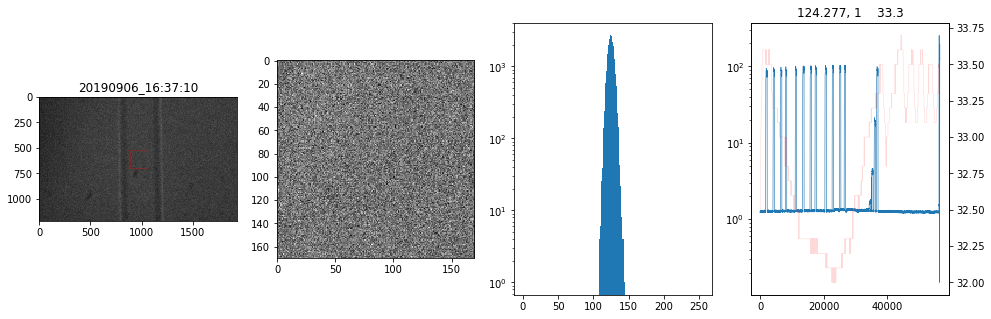

In [7]:
update_iter = 6
win = 85

w = core.getImageWidth()
h = core.getImageHeight()
roi = (slice(h/2-win,h/2+win), slice(w/2-win,w/2+win))
img = core.getLastImageMD(md)
t_start = mm_time() - mmt_offset
t_prev = t_start
msk = np.ones_like(img)
msk[roi] = 0

d={}
d['t'] = []
d['timestamp'] = []
d['roi_mean'] = []
d['roi_std'] = []
d['degC'] = []
d['cb_count'] = []
core.clearCircularBuffer()
try:
    while True:
        time.sleep(.0001) # other stuff
        while core.getRemainingImageCount() > 0:
            img = core.popNextImageMD(md)
            d['t'].append(mm_time() - mmt_offset)
            d['timestamp'].append(time.strftime("%Y%m%d_%H:%M:%S", time.localtime(d['t'][-1])))
            d['roi_mean'].append(img[roi].mean())
            d['roi_std'].append(img[roi].std())
            d['degC'].append(float(core.getProperty('camera-asi','CCDTemperature')))
            d['cb_count'].append(core.getRemainingImageCount())
            time_sys = time.time()

            if (len(d['t'])%update_iter==update_iter-1):
                plot(d)
                disp.clear_output(wait=True)
                plt.show()
                
                
# click 'interrupt' to exit gracefully
except KeyboardInterrupt:
#     pass

    ts = time.strftime("%Y%m%d-%H%M", time.localtime())
    disp.clear_output(wait=True)
    plot(d)
    plt.savefig('data/{}.png'.format(ts), dpi=600)
    print 'Acquisition Stopped: {}'. format(ts)
    df = pd.DataFrame(d, columns=['t','timestamp','roi_mean','roi_std','degC','cb_count'])
    df.to_csv('data/{}_data.csv'.format(ts), index=False)

In [ ]:
temps = []
for i in range(1000):
    temps.append(float(core.getProperty('camera-asi','CCDTemperature')))
    time.sleep(.1)
    
    plt.plot(temps, lw=.7, color='red')
    disp.clear_output(wait=True)
    plt.show()

# Cleanup

In [8]:
core.stopSequenceAcquisition()
core.setProperty('lamp-hal', 'State', 0)

In [9]:
core.unloadAllDevices()
del(core)

# OLD

In [5]:
# gui.snap(core, mode='cv2')
exposure_hold = core.getExposure()
core.stopSequenceAcquisition()
core.setExposure(250)
time.sleep(.5)
gui.video(core)

LIVE
To stop, click window + press ESC
STOPPED


In [ ]:
core.startContinuousSequenceAcquisition(exposure_hold)

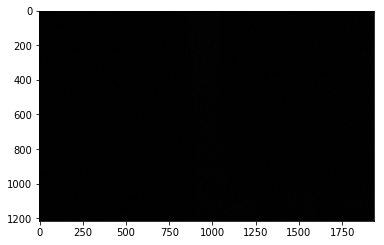

In [27]:
def acquire(exposure=300):
    core.setExposure(exposure)
    
#     core.setShutterOpen('shutter',1)
    core.waitForDevice('shutter')
    core.snapImage()
    core.waitForDevice(core.getCameraDevice())
#     core.setShutterOpen('shutter',0)

    return core.getImage()

img = acquire()
plt.imshow(img, 'gray',vmin=0,vmax=2**core.getImageBitDepth()-1)
plt.show()